In [1]:
import numpy as np
import h5py
    
    
def load_dataset():
    
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


# Logistic Regression with a Neural Network : Developing a NN Mindset


## 1 - Import Important Packages


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

## 2 - Overview of the Problem set

**Problem Statement**: You are given a dataset ("data.h5") containing: - a training set of m_train images labeled as cat (y=1) or non-cat (y=0) - a test set of m_test images labeled as cat or non-cat - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB). Thus, each image is square (height = num_px) and (width = num_px).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.


In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [0], it's a 'non-cat' picture.


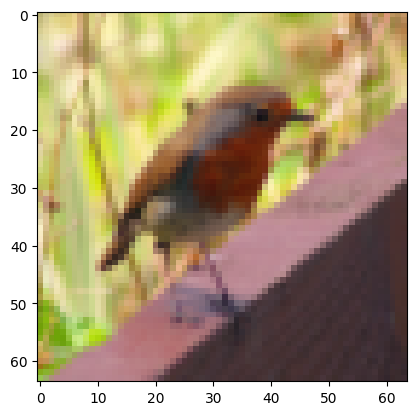

In [4]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64


In [6]:
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")   
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [7]:
test_set_x_orig.shape

(50, 64, 64, 3)

In [8]:
test_set_y.shape

(1, 50)

In [9]:
print(test_set_x_orig.shape[0])
print(test_set_x_orig.shape[1])
print(test_set_x_orig.shape[2])
print(test_set_x_orig.shape[3])

50
64
64
3


Reshape images of shape (num_px, num_px, 3) in a numpy-array of shape (num_px $*$ num_px $*$ 3, 1). After this, our training (and test) dataset is a numpy-array where each column represents a flattened image. There should be m_train (respectively m_test) columns.
Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px $*$ num_px $*$ 3, 1).

```python
X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X
```


In [10]:
n_examples_test = train_set_x_orig.shape[0]
train_num_px = train_set_x_orig.shape[1]
train_depth = train_set_x_orig.shape[3]

train_set_x_flatten = train_set_x_orig.reshape(train_num_px * train_num_px * train_depth , n_examples_test )


In [11]:
#test date information
n_examples_test = test_set_x_orig.shape[0]
test_num_px = test_set_x_orig.shape[1]
test_depth = test_set_x_orig.shape[3]

test_set_x_flatten =  test_set_x_orig.reshape(test_num_px * test_num_px * test_depth , n_examples_test )

In [12]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 71 49 38 70]


### Standardise the Dataset

Pre-processing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).


In [13]:
train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

## 3 - General Architecture of the learning algorithm

<img src="image/LogReg_kiank.png" style="width:650px;height:400px;">

For example $x^{(i)}$:

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$
$$ \mathcal{L}(a^{(i)}, y^{(i)}) = - y^{(i)} \log(a^{(i)}) - (1-y^{(i)} ) \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum\_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$


### 4.1 - Helper functions

Implement Sigmoid :


In [24]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [25]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 4.2 - Initializing parameters

Implement parameter initialization.
W as a vector of zeros.


In [26]:
def intialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w,b

In [27]:
dim = 2 
w , b = intialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [28]:
# Transpose gives us 
w.T

array([[0., 0.]])

Note : For image inputs, w will be of shape (num_px $\times$ num_px $\times$ 3, 1).


### 4.3 - Forward and Backward propagation

Function `propagate()` that computes the cost function and its gradient.

Forward Propagation:

- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the binary cross entropy loss cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum\_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$


In [29]:
# GRADED FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [30]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 4.4 - Optimization

Optimization function : 

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [49]:
from tqdm import trange

def optimize( w , b , X , Y , num_iterations , learning_rate , print_cost = False ):
    '''
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    '''

    costs = []

    for i in  (t := trange(num_iterations)):
        grads , cost = propagate(w , b , X , Y)
        
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0 :
            costs.append(cost)

        if print_cost and i % 100 == 0 :
            print("Cost after iteration %i : %f" %(i , cost))

    params = {"w" : w , "b" : b}
    grads = {"dw" : dw , "db" : db}

    return params , grads , costs


In [50]:
# Find data type of grads
type(grads)

dict

In [53]:

params, grads, costs = optimize(w, b, X, Y, num_iterations= 10000, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 49869.56it/s]

w = [[-3.85254014]
 [ 0.33879373]]
b = 4.399519758655355
dw = [[ 0.02554455]
 [-0.0063286 ]]
db = -0.016475914204804886


Cost Function plotting

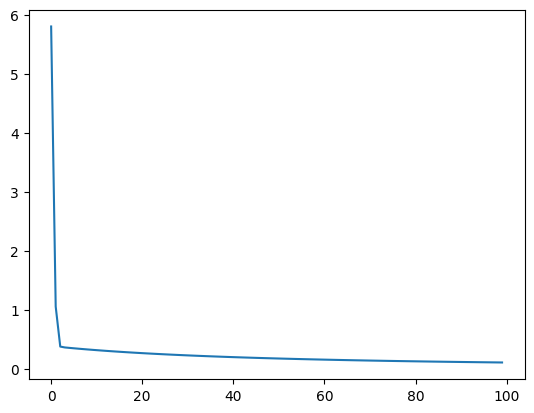

In [54]:
import matplotlib.pyplot as plt
plt.plot(costs)

Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [55]:
def predict(w,b,X):

    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    num_examples = X.shape[1]
    # Initialize Y_prediction as a numpy array with zeros
    Y_prediction = np.zeros((1,num_examples))

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X) + b)
    Y_prediction = (A >= 0.5) * 1.0

    assert(Y_prediction.shape == (1, num_examples))
    return Y_prediction

In [56]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## 5 - Merge all functions into a model ##


In [57]:
def model(X_train , Y_train , X_test , Y_test , num_iterations = 2000 , learning_rate = 0.5 , print_cost = False):

    # Initialize parameters with zeros
    num_examples = X_train.shape[0]

    w , b = intialize_with_zeros(num_examples)

    # Gradient descent
    parameters , grads , costs = optimize(w , b , X_train , Y_train , num_iterations , learning_rate , print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w , b = parameters["w"] , parameters["b"]

    # Predict test/train set examples
    Y_prediction_test = predict(w , b , X_test)
    Y_prediction_train = predict(w , b , X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs" : costs ,
         "Y_prediction_test" : Y_prediction_test ,
         "Y_prediction_train" : Y_prediction_train ,
         "w" : w ,
         "b" : b ,
         "learning_rate" : learning_rate ,
         "num_iterations" : num_iterations}

    return d

In [59]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:04<00:00, 80.18it/s]

train accuracy: 100.0 %
test accuracy: 34.0 %


y = [0], it's a 'non-cat' picture.


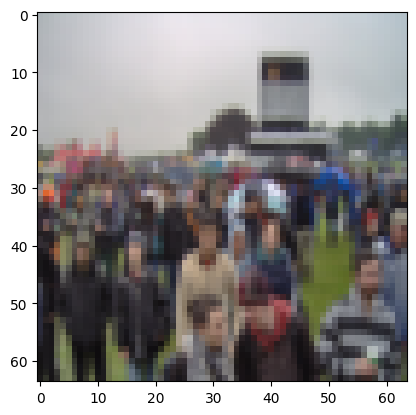

In [62]:
# Example of a picture that was wrongly classified.
index = 100
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

Let's also plot the cost function and the gradients.

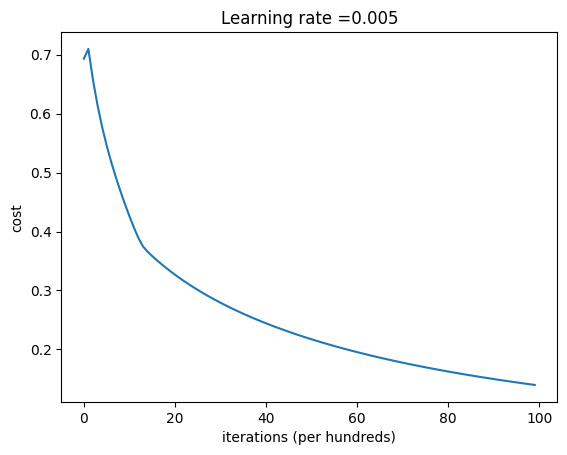

In [63]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## 6 - Further analysis : Learning Rate Analysis ##
Comparing the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens.

 Learning Rate is :0.01


100%|██████████| 1500/1500 [00:26<00:00, 57.34it/s] 


train accuracy: 71.29186602870814 %
test accuracy: 64.0 %

-------------------------------------------------------

 Learning Rate is :0.001


100%|██████████| 1500/1500 [00:19<00:00, 78.89it/s] 


train accuracy: 74.16267942583733 %
test accuracy: 34.0 %

-------------------------------------------------------

 Learning Rate is :0.0001


100%|██████████| 1500/1500 [00:19<00:00, 75.73it/s] 


train accuracy: 66.02870813397129 %
test accuracy: 34.0 %

-------------------------------------------------------



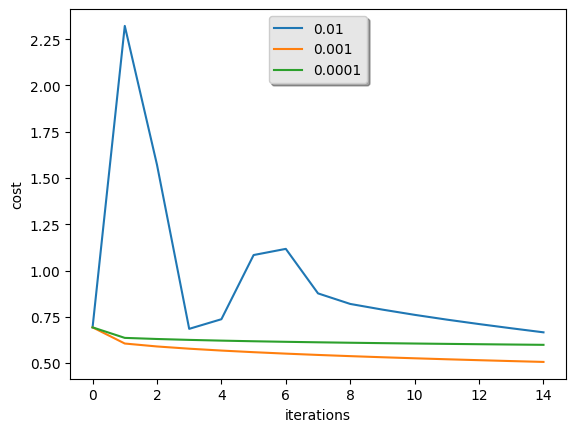

In [64]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for rate in learning_rates:
    print( " Learning Rate is :" + str(rate))
    models[str(rate)] = model(train_set_x , train_set_y , test_set_x , test_set_y , num_iterations = 1500 , learning_rate = rate , print_cost = False)
    print('\n' + "-------------------------------------------------------" + '\n')

for rate in learning_rates:
    plt.plot(np.squeeze(models[str(rate)]["costs"]) , label = str(models[str(rate)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc = 'upper center' , shadow = True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


Resources:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/